# Samsung Innovation Campus (JAVS PY) | Proyecto Final

### Importando librerias

In [38]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [27]:
# Cargar los datos de MovieLens
columnas_ratings = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('data/rating.csv')

# Limitar a 100,000 registros
ratings = ratings.sample(n=100000, random_state=42).reset_index(drop=True)

# Cargar los datos de películas para tener los nombres de las películas (opcional)
columnas_peliculas = ['movieId', 'title', 'genres']
movies = pd.read_csv('data/movie.csv')

In [17]:
# Normalizar las entradas
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

# Normalizar los ratings
scaler = MinMaxScaler()
ratings['rating'] = scaler.fit_transform(ratings[['rating']])

# Crear conjunto de entrenamiento y prueba
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Crear variables para el modelo
x_train = [train['user'].values, train['movie'].values]
y_train = train['rating'].values
x_test = [test['user'].values, test['movie'].values]
y_test = test['rating'].values

In [ ]:
# Definir entradas
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

In [20]:
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Detener el entrenamiento si el error de validación no mejora en 5 épocas

# Entrenar el modelo con diferentes configuraciones
batch_sizes = [32, 64, 128] # Tamaños de lote, es decir, cuántas muestras se utilizan para calcular el error y actualizar los pesos
embedding_sizes = [20, 50, 100] # Tamaño de los vectores de embedding, es decir, cuántas dimensiones tiene el espacio latente
learning_rates = [0.001, 0.0005, 0.0001] # Tasa de aprendizaje, es decir, cuánto se actualizan los pesos en cada paso

best_mae = float('inf') # Inicializar el mejor error absoluto medio
best_model = None # Inicializar el mejor modelo

for batch_size in batch_sizes: # Recorrer los tamaños de lote
    for embedding_size in embedding_sizes: # Recorrer los tamaños de embedding
        for lr in learning_rates: # Recorrer las tasas de aprendizaje

            # Construir el modelo

            # Capa de embedding para los usuarios
            user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)

            # Capa de embedding para las películas
            movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

            # Aplanar las capas de embedding
            user_vector = Flatten()(user_embedding)
            movie_vector = Flatten()(movie_embedding)

            # Producto punto entre los vectores de usuario y película
            dot_user_movie = Dot(axes=1)([user_vector, movie_vector])

            # Capas densas 

            dense_1 = Dense(256, activation='relu')(dot_user_movie) # Se puede usar la concatenación de los vectores de usuario y película
            batch_norm_1 = BatchNormalization()(dense_1) # Normalización de los valores de salida
            dropout_1 = Dropout(0.5)(batch_norm_1) # Dropout para evitar sobreajuste

            dense_2 = Dense(128, activation='relu')(dropout_1) 
            batch_norm_2 = BatchNormalization()(dense_2)
            dropout_2 = Dropout(0.5)(batch_norm_2)

            dense_3 = Dense(64, activation='relu')(dropout_2)
            batch_norm_3 = BatchNormalization()(dense_3)
            dropout_3 = Dropout(0.5)(batch_norm_3)

            output = Dense(1)(dropout_3) # Capa de salida
            model = Model(inputs=[user_input, movie_input], outputs=output) # Crear el modelo
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['mae']) # Compilar el modelo
            
            # Entrenar el modelo
            history = model.fit(
                x=x_train,
                y=y_train,
                batch_size=batch_size,
                epochs=50,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=[early_stopping]
            )
            
            # Evaluar el modelo
            loss, mae = model.evaluate(x_test, y_test, verbose=1) # Calcular el error y el error absoluto medio
            print(f'Batch size: {batch_size}, Embedding size: {embedding_size}, Learning rate: {lr}, Loss: {loss}, MAE: {mae}') # Imprimir los resultados
            
            if mae < best_mae: # Si el error absoluto medio es mejor que el mejor error absoluto medio
                best_mae = mae
                best_model = model
                best_params = (batch_size, embedding_size, lr)

print(f'Best MAE: {best_mae} with batch size: {best_params[0]}, embedding size: {best_params[1]}, learning rate: {best_params[2]}')


Epoch 1/50
2500/2500 [==============================] - 82s 31ms/step - loss: 0.2379 - mae: 0.3053 - val_loss: 0.0546 - val_mae: 0.1868
Epoch 2/50
2500/2500 [==============================] - 66s 26ms/step - loss: 0.0557 - mae: 0.1891 - val_loss: 0.0545 - val_mae: 0.1868
Epoch 3/50
2500/2500 [==============================] - 74s 30ms/step - loss: 0.0551 - mae: 0.1874 - val_loss: 0.0542 - val_mae: 0.1856
Epoch 4/50
2500/2500 [==============================] - 75s 30ms/step - loss: 0.0480 - mae: 0.1715 - val_loss: 0.0542 - val_mae: 0.1830
Epoch 5/50
2500/2500 [==============================] - 60s 24ms/step - loss: 0.0372 - mae: 0.1480 - val_loss: 0.0596 - val_mae: 0.1820
Epoch 6/50
2500/2500 [==============================] - 82s 33ms/step - loss: 0.0291 - mae: 0.1312 - val_loss: 0.0658 - val_mae: 0.1943
Epoch 7/50
2500/2500 [==============================] - 65s 26ms/step - loss: 0.0237 - mae: 0.1201 - val_loss: 0.0625 - val_mae: 0.1871
Epoch 8/50
2500/2500 [==========================

In [21]:
# Evaluar el mejor modelo
loss, mae = best_model.evaluate(x_test, y_test, verbose=1)
print(f'Best Model - Loss: {loss}, MAE: {mae}')

625/625 [==============================] - 4s 7ms/step - loss: 0.0542 - mae: 0.1830
Best Model - Loss: 0.05418727546930313, MAE: 0.1830020397901535


In [37]:
# Mostrar la arquitectura del mejor modelo
best_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        1042240     ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 20)        169320      ['movie_input[0][0]']            
                                                                                            

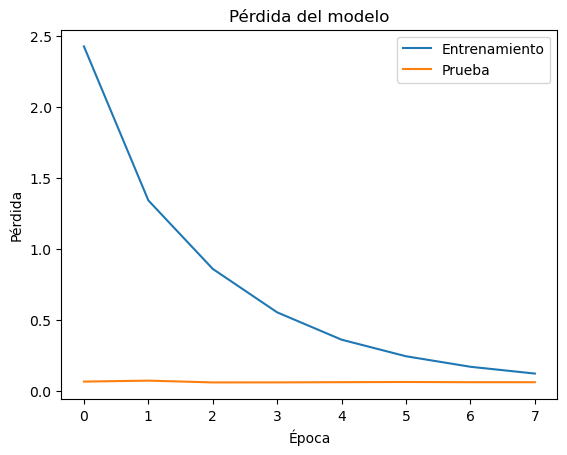

In [44]:
# Graficar la pérdida del modelo, tanto en entrenamiento como en prueba

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper right')
plt.show()

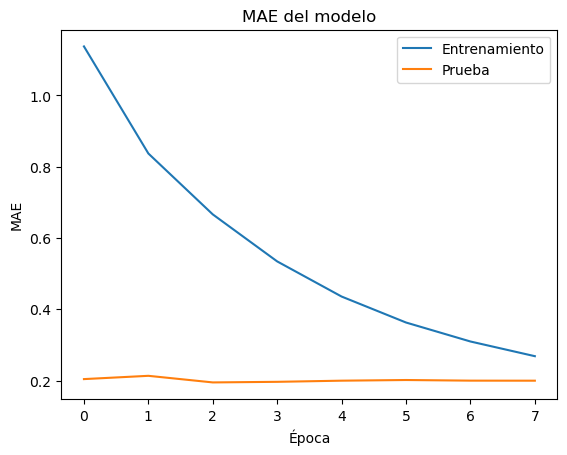

In [45]:
# Graficar el MAE del modelo, tanto en entrenamiento como en prueba
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE del modelo')
plt.ylabel('MAE')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper right')
plt.show()

625/625 [==============================] - 7s 9ms/step


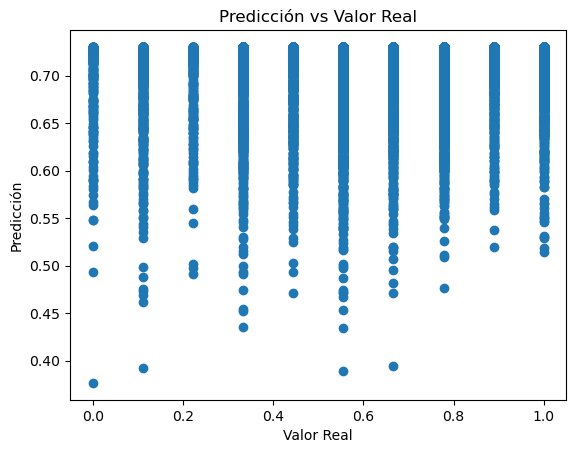

In [46]:
# Graficar la predicción vs el valor real
y_pred = best_model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicción vs Valor Real')
plt.show()

In [50]:
# Esta función recomienda películas para un usuario dado, tomando en cuenta las películas que ya ha visto y las calificaciones que les ha dado.
def recommend_movies(user_id, num_recommendations=5):
    # Codificar el usuario
    user_encoded = user2user_encoded[user_id]
    
    # Crear una matriz de usuario-película para todas las películas
    user_movie_array = np.hstack(
        ([[user_encoded]] * num_movies, np.array(range(num_movies)).reshape(-1, 1))
    )
    
    # Predecir las calificaciones usando el modelo
    predictions = best_model.predict([user_movie_array[:, 0], user_movie_array[:, 1]])
    
    # Obtener las calificaciones predichas
    pred_ratings = np.squeeze(predictions)
    
    # Ordenar las películas por calificación predicha y seleccionar las mejores
    top_indices = pred_ratings.argsort()[-num_recommendations:][::-1]
    
    # Obtener los IDs y nombres de las películas recomendadas
    recommended_movie_ids = [movie_ids[i] for i in top_indices]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies[['movieId', 'title']]

In [57]:
# Recomendar películas para un usuario
# user_id = 49018
# user_id = 119148
# user_id = 112292
# user_id = 77297
# user_id = 119207
user_id = 97868

recommendations = recommend_movies(user_id, 10)
print(f'Recomendaciones para el usuario: {user_id}:')
display(recommendations)

265/265 [==============================] - 12s 43ms/step
Recomendaciones para el usuario: 97868:


,movieId,title
587,593,"Silence of the Lambs, The (1991)"
1062,1084,Bonnie and Clyde (1967)
1254,1282,Fantasia (1940)
1940,2024,"Rapture, The (1991)"
4411,4506,Frantic (1988)
5258,5355,"Cassandra Crossing, The (1976)"
8115,8798,Collateral (2004)
15208,77658,Cosmos (1980)
21061,102802,"Lords of Salem, The (2012)"
27132,130512,Hippocrates (2014)


In [54]:
# Guardar el modelo, para poder cargarlo en nuestra API
best_model.save('model.h5')